In [16]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from matplotlib import pylab as plt
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller  
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from plotly.subplots import make_subplots
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.models import ExponentialSmoothing


In [17]:
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [18]:
energy = pd.read_csv('./dataset/long_data_.csv')
diff = energy[['Usage']].diff().dropna()


In [19]:
energy['Dates'] = pd.to_datetime(energy['Dates'])
energy = energy[['Dates', 'Usage']]
energy = energy.groupby(energy['Dates'], as_index=False).mean()
energy


,Dates,Usage
0,2019-01-07,103.736364
1,2019-01-08,113.951515
2,2019-01-09,107.836364
3,2019-01-10,98.045455
4,2019-01-11,84.463636
...,...,...
493,2020-05-19,107.051515
494,2020-05-20,107.712121
495,2020-05-21,107.730303
496,2020-05-22,106.518182


In [20]:
print(energy.isnull().sum())

Dates    0
Usage    0
dtype: int64


In [21]:
fig = px.line(energy, x='Dates', y='Usage')
fig.show()

In [22]:
kpss_test = kpss(energy['Usage'], regression='c')

# Print the test statistic and p-value
print(f"KPSS test statistic: {kpss_test[0]}")
print(f"p-value: {kpss_test[1]}")


KPSS test statistic: 0.03665416807855581
p-value: 0.1


c:\Users\avish\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [23]:
adf_test = adfuller(energy['Usage'])

# Print the test statistic, p-value, and critical values
print(f"ADF test statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Critical values:")
for key, value in adf_test[4].items():
    print(f"\t{key}: {value}")


ADF test statistic: -6.694366443974222
p-value: 4.034436548427149e-09
Critical values:
	1%: -3.4437936797256317
	5%: -2.867468682890213
	10%: -2.5699277594606915


In [24]:
class TargetTransformer:
    """
    Perform some transformation on the time series
    data in order to make the model more performant and
    avoid non-stationary effects.
    """

    def __init__(self, log=False, detrend=False, diff=False):

        self.trf_log = log
        self.trf_detrend = detrend
        self.trend = pd.Series(dtype=np.float64)

    def transform(self, index, values):
        """
        Perform log transformation to the target time series

        :param index: the index for the resulting series
        :param values: the values of the initial series

        Return:
            transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_detrend:
            self.trend = TargetTransformer.get_trend(res) - np.mean(res.values)
            res = res.subtract(self.trend)

        if self.trf_log:
            res = pd.Series(index=index, data=np.log(res.values))

        return res

    def inverse(self, index, values):
        """
        Go back to the original time series values

        :param index: the index for the resulting series
        :param values: the values of series to be transformed back

        Return:
            inverse transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_log:
            res = pd.Series(index=index, data=np.exp(values))
        try:
            if self.trf_detrend:
                assert len(res.index) == len(self.trend.index)
                res = res + self.trend

        except AssertionError:
            print("Use a different transformer for each target to transform")

        return res

    @staticmethod
    def get_trend(data):
        """
        Get the linear trend on the data which makes the time
        series not stationary
        """
        n = len(data.index)
        X = np.reshape(np.arange(0, n), (n, 1))
        y = np.array(data)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        return pd.Series(index=data.index, data=trend)


In [25]:
def ts_analysis_plots(data, n_lags=100):

    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelation functions for the loads
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):
            ax.axvline(x=24*i, ymin=0.0, ymax=1.0, color='grey', ls="--")

    # AD Fuller test and linear trend of the time series
    trend = TargetTransformer.get_trend(data)
    adf = adfuller(data)

    fig, axs = plt.subplots(2, 2, figsize=(25, 12))
    axs = axs.flat

    # original time series
    axs[0].plot(data, color='#0504aa')
    axs[0].plot(trend, color="red")
    axs[0].set(xlabel="Date", ylabel="KWh",
               title=f"Energy consumption over time (ADF p-value: {round(adf[1],20)})")

    # histogram of value distribution
    axs[1].hist(data, bins=10, width=3, color='#0504aa', alpha=0.7)
    axs[1].set(xlabel="KWh", ylabel="# data points",
               title="Energy values distribution")

    # autocorrelation function
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="lag", ylabel="ACF value")

    # partial autocorrelation function
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="lag", ylabel="PACF value")

    plt.show()


c:\Users\avish\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



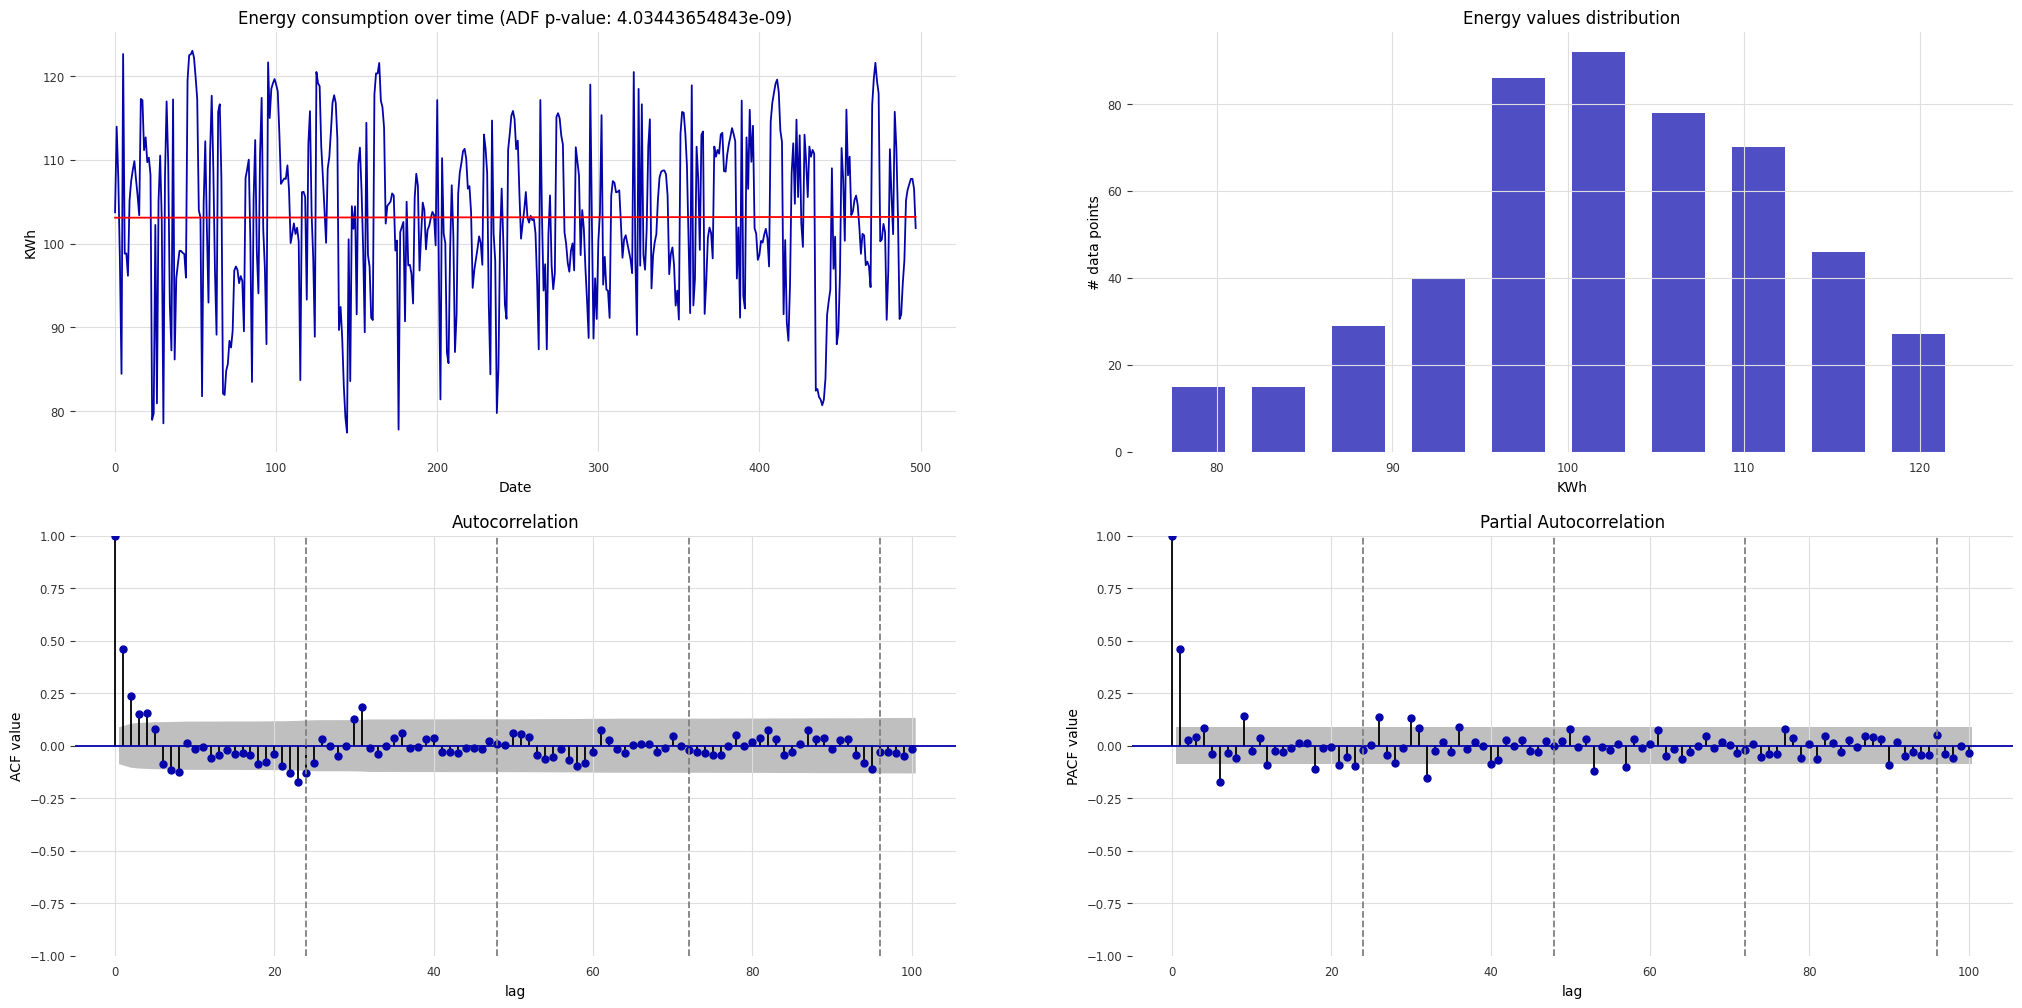

In [26]:
ts_analysis_plots(energy["Usage"])

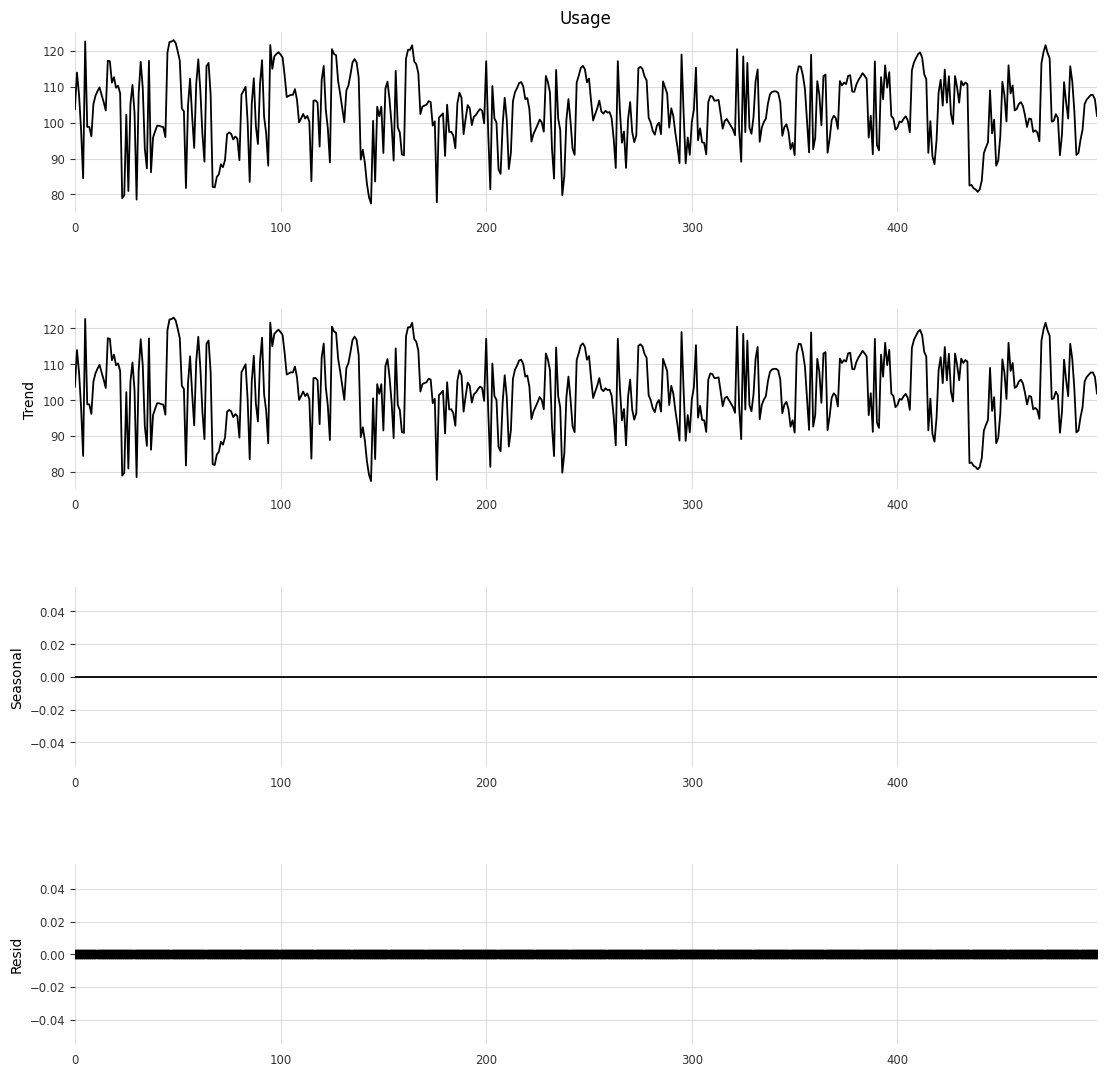

In [27]:
energy_data = energy["Usage"]
# date = energy.index[1] - pd.Timedelta(weeks=4)
# energy_data = energy[energy.index > date]

res = seasonal_decompose(energy_data, model='additive',  period=1)
fig = res.plot()
fig.set_size_inches((12, 12))


In [28]:
energy_data = energy["Usage"]
date = energy.index[1] - pd.Timedelta(weeks=4)
energy_data = energy[energy.index > date]

res = seasonal_decompose(energy_data, model='additive')
fig = res.plot()
fig.set_size_inches((12, 12))



TypeError: unsupported operand type(s) for -: 'int' and 'Timedelta'

In [29]:

model = ARIMA(energy['Usage'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Usage   No. Observations:                  498
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1784.959
Date:                Wed, 26 Apr 2023   AIC                           3577.918
Time:                        11:04:06   BIC                           3594.760
Sample:                             0   HQIC                          3584.528
                                - 498                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.1402      0.792    130.226      0.000     101.588     104.692
ar.L1          0.5224      0.082      6.335      0.000       0.361       0.684
ma.L1         -0.0812      0.090     -0.906      0.3

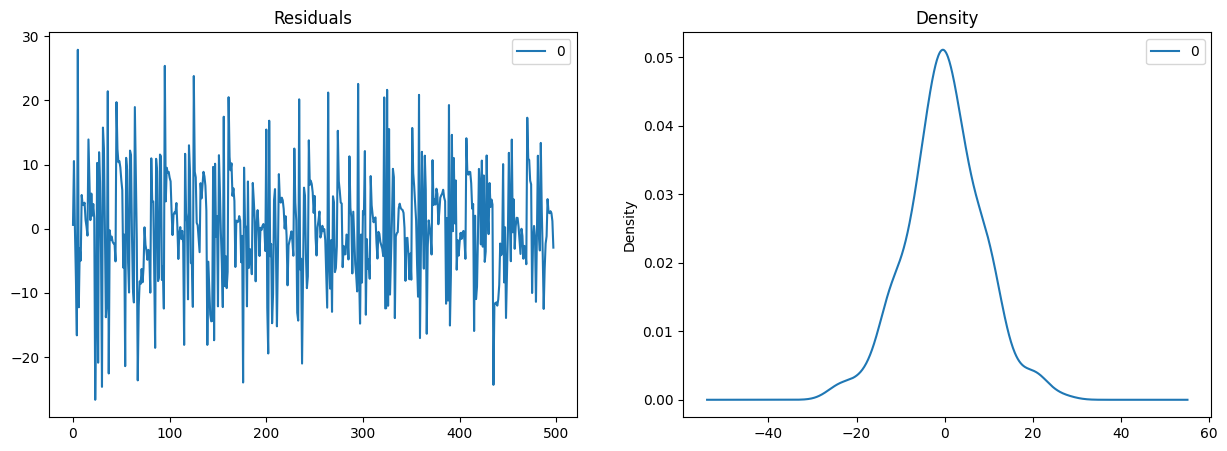

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


<---A normally distributed residual plot will appear roughly bell-shaped, with a symmetric peak centered around zero, while a non-normally distributed residual plot may exhibit skewness or other deviations from normality.--->

In [1]:


model = ExponentialSmoothing()
model.fit(energy['Usage'])

# Make a forecast
forecast = model.predict(12)


NameError: name 'ExponentialSmoothing' is not defined

In [ ]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=residuals.index, y=residuals[0], name='Residuals'))
fig.update_layout(title='ARIMA Model Residuals')
fig.show()
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=residuals[0], name='Residuals Density', nbinsx=30))
fig.update_layout(title='Density Plot of ARIMA Model Residuals')
fig.show()


In [ ]:
fitted_values = model_fit.fittedvalues

# Create a Plotly scatter plot of the actuals and fitted values
fig = go.Figure()
fig.add_trace(go.Scatter(x=energy.index,
              y=energy['Usage'], mode='lines', name='Actuals'))
fig.add_trace(go.Scatter(x=fitted_values.index,
              y=fitted_values, mode='lines', name='Fitted'))

# Update the layout of the plot
fig.update_layout(title='Actuals vs. Fitted Values')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Energy Usage')

# Show the plot
fig.show()


In [ ]:
forecast=fitted_values
actual=energy['Usage']
# Accuracy metrics


def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
                    # ACF1
    return ({'mape': mape, 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
             'corr': corr})


forecast_accuracy(forecast, actual)


C:\Users\avish\AppData\Local\Temp\ipykernel_1748\2939955457.py:13: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\avish\AppData\Local\Temp\ipykernel_1748\2939955457.py:14: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\avish\AppData\Local\Temp\ipykernel_1748\2939955457.py:15: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\avish\AppData\Local\Temp\ipykernel_1748\2939955457.py:16: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

{'mape': 0.06634803386617144,
 'me': 0.0010930436965106347,
 'mae': 6.678705588596204,
 'mpe': 0.007521133862710741,
 'rmse': 8.715297735229708,
 'corr': 0.46056324869726745}

MAPE (Mean Absolute Percentage Error) measures the average percentage difference between predicted and actual values. A value of 0.0702 means that, on average, your predictions are off by 6.42% from the actual values. This could be considered good or bad depending on the context of the problem.

ME (Mean Error) measures the average difference between predicted and actual values. A value of 0.0024 means that, on average, your predictions are off by 0.0024 units from the actual values. This is a relatively small error, but again, it depends on the context.

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. A value of 6.4684 means that, on average, your predictions are off by 6.4684 units from the actual values. This metric is useful for understanding the magnitude of the errors.

MPE (Mean Percentage Error) measures the average percentage difference between predicted and actual values, but with the difference divided by the actual value. A value of 0.0072 means that, on average, your predictions are off by 0.72% from the actual values. This metric can be useful for problems where the scale of the data varies widely.

RMSE (Root Mean Squared Error) measures the square root of the average squared difference between predicted and actual values. A value of 8.5075 means that, on average, your predictions are off by 8.5075 units from the actual values. This metric is similar to MAE, but it gives more weight to large errors.

Correlation (corr) measures the linear relationship between predicted and actual values. A value of 0.4992 means that there is a moderate positive correlation between your predictions and the actual values.

Overall, it seems that your model is performing reasonably well, but the accuracy ultimately depends on the requirements of the problem and the context in which the model is being used.

In [ ]:
s_model = SARIMAX(energy['Usage'], order=(
    1, 0, 1), seasonal_order=(0, 0, 0, 12))
s_model_fit = s_model.fit()

# Print the summary of the SARIMA model
print(s_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Usage   No. Observations:                  498
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1823.251
Date:                Sun, 16 Apr 2023   AIC                           3652.501
Time:                        12:22:08   BIC                           3665.133
Sample:                             0   HQIC                          3657.459
                                - 498                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.002    544.001      0.000       0.996       1.003
ma.L1         -0.5643      0.036    -15.643      0.000      -0.635      -0.494
sigma2        87.7031      5.223     16.793      0.0

In [ ]:
predicted_values = s_model_fit.predict(start=0, end=len(energy)-1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=energy.index,
              y=energy['Usage'], name='Actual Usage'))
fig.add_trace(go.Scatter(x=energy.index,
              y=predicted_values, name='Predicted Usage'))
fig.update_layout(xaxis_title='Date', yaxis_title='Energy Usage')
fig.show()


In [ ]:
Aforecast = predicted_values
actual = energy['Usage']
# Accuracy metrics

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    return ({'mape': mape, 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
             'corr': corr})

forecast_accuracy(Aforecast, actual)


C:\Users\avish\AppData\Local\Temp\ipykernel_1748\2380470398.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\avish\AppData\Local\Temp\ipykernel_1748\2380470398.py:13: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\avish\AppData\Local\Temp\ipykernel_1748\2380470398.py:14: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\avish\AppData\Local\Temp\ipykernel_1748\2380470398.py:15: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

{'mape': 0.07120862631111725,
 'me': -0.3875884494414248,
 'mae': 7.203301433105229,
 'mpe': 0.003022711589442119,
 'rmse': 10.450285848606912,
 'corr': 0.34217604757573145}

# ***AR Modal***

                            AutoReg Model Results                             
Dep. Variable:                  Usage   No. Observations:                  498
Model:                     AutoReg(1)   Log Likelihood               -1782.024
Method:               Conditional MLE   S.D. of innovations              8.729
Date:                Sun, 16 Apr 2023   AIC                           3570.047
Time:                        12:22:09   BIC                           3582.673
Sample:                             1   HQIC                          3575.003
                                  498                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.7301      4.128     13.502      0.000      47.640      63.820
Usage.L1       0.4596      0.040     11.538      0.000       0.382       0.538
                                    Roots           

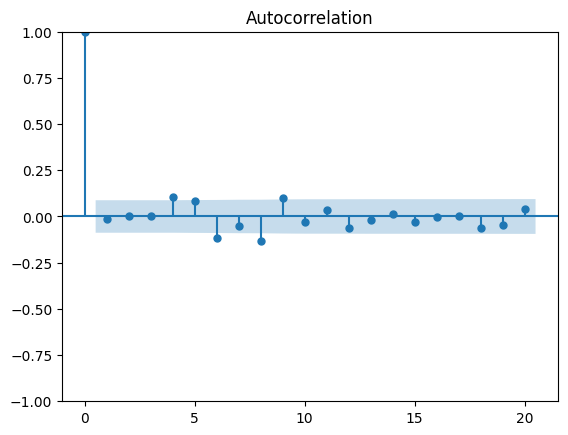

In [ ]:
actual_values = energy['Usage'][-30:]
ar_model = AutoReg(energy['Usage'], lags=1)
ar_model_fit = ar_model.fit()
print(ar_model_fit.summary())
plot_acf(ar_model_fit.resid, lags=20)
predictions = ar_model_fit.predict(
    start=len(energy), end=len(energy)+29, dynamic=False)
print(predictions)

corr = np.corrcoef(predictions, actual_values)[0, 1]
print(corr)


# **LSTM**

Epoch 1/150
5/5 - 7s - loss: 0.2751 - 7s/epoch - 1s/step
Epoch 2/150
5/5 - 0s - loss: 0.1431 - 85ms/epoch - 17ms/step
Epoch 3/150
5/5 - 0s - loss: 0.0665 - 76ms/epoch - 15ms/step
Epoch 4/150
5/5 - 0s - loss: 0.0543 - 81ms/epoch - 16ms/step
Epoch 5/150
5/5 - 0s - loss: 0.0630 - 61ms/epoch - 12ms/step
Epoch 6/150
5/5 - 0s - loss: 0.0517 - 56ms/epoch - 11ms/step
Epoch 7/150
5/5 - 0s - loss: 0.0493 - 77ms/epoch - 15ms/step
Epoch 8/150
5/5 - 0s - loss: 0.0520 - 78ms/epoch - 16ms/step
Epoch 9/150
5/5 - 0s - loss: 0.0513 - 66ms/epoch - 13ms/step
Epoch 10/150
5/5 - 0s - loss: 0.0488 - 61ms/epoch - 12ms/step
Epoch 11/150
5/5 - 0s - loss: 0.0484 - 105ms/epoch - 21ms/step
Epoch 12/150
5/5 - 0s - loss: 0.0490 - 104ms/epoch - 21ms/step
Epoch 13/150
5/5 - 0s - loss: 0.0486 - 73ms/epoch - 15ms/step
Epoch 14/150
5/5 - 0s - loss: 0.0478 - 59ms/epoch - 12ms/step
Epoch 15/150
5/5 - 0s - loss: 0.0475 - 63ms/epoch - 13ms/step
Epoch 16/150
5/5 - 0s - loss: 0.0474 - 60ms/epoch - 12ms/step
Epoch 17/150
5/5 - 

c:\Users\avish\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\avish\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning:

divide by zero encountered in divide

c:\Users\avish\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning:

invalid value encountered in multiply



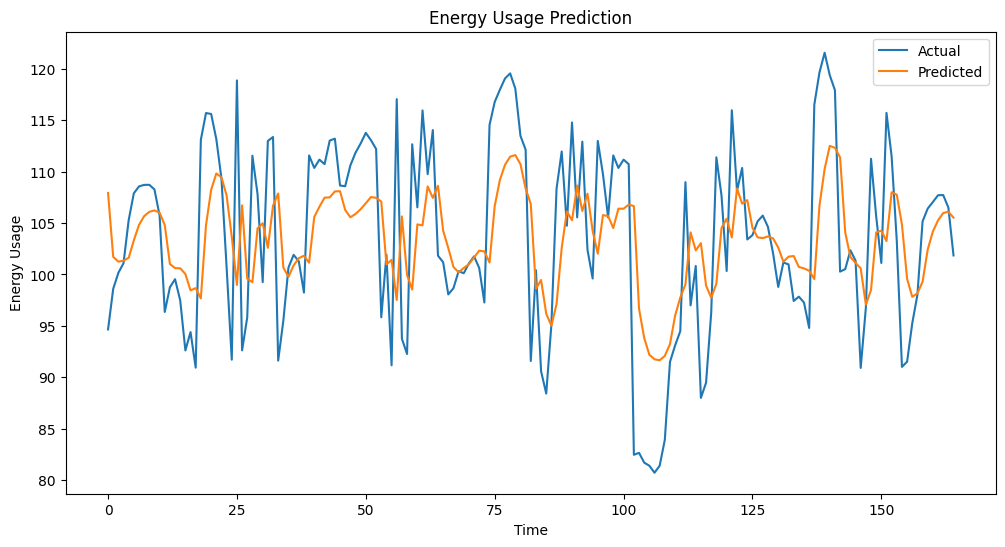

In [ ]:
# select the USAGE column and convert it to a numpy array
usage = energy["Usage"].values

# normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
usage = scaler.fit_transform(usage.reshape(-1, 1))

# split the data into training and test sets
train_size = int(len(usage) * 0.65)
test_size = len(usage) - train_size
train_data, test_data = usage[0:train_size, :], usage[train_size:len(usage), :]

# convert the data into sequences


def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


seq_length = 10
train_X, train_y = create_sequences(train_data, seq_length)
test_X, test_y = create_sequences(test_data, seq_length)

# reshape the data to be 3-dimensional (batch_size, time_steps, features)
train_X = np.reshape(train_X, (train_X.shape[0], seq_length, 1))
test_X = np.reshape(test_X, (test_X.shape[0], seq_length, 1))

# define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# train the LSTM model
model.fit(train_X, train_y, epochs=150, batch_size=72, verbose=2)

# make predictions on test data
y_pred = model.predict(test_X)

# invert the normalization
y_pred = scaler.inverse_transform(y_pred)
test_y = scaler.inverse_transform(test_y.reshape(-1, 1))

# evaluate the performance of the model

mse = np.mean((test_y - y_pred)**2)
Aforecast = y_pred
actual = test_y
# Accuracy metrics

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    return ({'mape': mape, 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
             'corr': corr})

print(forecast_accuracy(Aforecast, actual))

print("Mean Squared Error:", mse)
plt.rcParams['figure.figsize'] = [12, 6]
plt.plot(test_y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Usage')
plt.title('Energy Usage Prediction')
plt.legend()
plt.show()


**FB Prophet**

In [ ]:
energy.columns = ['ds', 'y']
energy.head()

,ds,y
0,2019-01-07,103.736364
1,2019-01-08,113.951515
2,2019-01-09,107.836364
3,2019-01-10,98.045455
4,2019-01-11,84.463636


In [ ]:
model = Prophet()


In [ ]:
model.fit(energy)


12:44:04 - cmdstanpy - INFO - Chain [1] start processing
12:44:04 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
model.component_modes


{'additive': ['weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [ ]:
future_dates = model.make_future_dataframe(
    periods=365, freq='d', include_history=True)
future_dates.shape


(863, 1)

In [ ]:
future_dates.head()


,ds
0,2019-01-07
1,2019-01-08
2,2019-01-09
3,2019-01-10
4,2019-01-11


In [ ]:
prediction=model.predict(future_dates)

In [ ]:
prediction.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-07,103.380234,91.247180,115.984265,103.380234,103.380234,-0.184897,-0.184897,-0.184897,-0.184897,-0.184897,-0.184897,0.0,0.0,0.0,103.195337
1,2019-01-08,103.378101,90.640688,116.765511,103.378101,103.378101,0.650456,0.650456,0.650456,0.650456,0.650456,0.650456,0.0,0.0,0.0,104.028557
2,2019-01-09,103.375967,90.063726,116.027985,103.375967,103.375967,0.151431,0.151431,0.151431,0.151431,0.151431,0.151431,0.0,0.0,0.0,103.527398
3,2019-01-10,103.373834,90.326534,115.947329,103.373834,103.373834,-0.293260,-0.293260,-0.293260,-0.293260,-0.293260,-0.293260,0.0,0.0,0.0,103.080574
4,2019-01-11,103.371700,89.923172,115.407487,103.371700,103.371700,-0.470863,-0.470863,-0.470863,-0.470863,-0.470863,-0.470863,0.0,0.0,0.0,102.900837


In [ ]:
trace_open = go.Scatter(
    x=prediction["ds"],
    y=prediction["yhat"],
    mode='lines',
    name="Forecast"
)
trace_high = go.Scatter(
    x=prediction["ds"],
    y=prediction["yhat_upper"],
    mode='lines',
    fill="tonexty",
    line={"color": "#57b8ff"},
    name="Higher uncertainty interval"
)
trace_low = go.Scatter(
    x=prediction["ds"],
    y=prediction["yhat_lower"],
    mode='lines',
    fill="tonexty",
    line={"color": "#57b8ff"},
    name="Lower uncertainty interval"
)
trace_close = go.Scatter(
    x=energy["ds"],
    y=energy["y"],
    name="Data values"
)

#make list for all three scattle objects.
data = [trace_open, trace_high, trace_low, trace_close]
# Construct a new Layout object.
#title - It will display string as a title of graph
layout = go.Layout(title="Power consumption forecasting")
#A list or tuple of trace instances (e.g. [Scatter(…), Bar(…)]) or A single trace instance (e.g. Scatter(…), Bar(…), etc.)
#A list or tuple of dicts of string/value properties where: - The ‘type’ property specifies the trace type.

fig = go.Figure(data=data)
fig.show()


In [ ]:
fig = go.Figure([go.Scatter(x=energy['ds'], y=energy['y'], mode='lines',
                            name='Actual')])
#You can add traces using an Express plot by using add_trace
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat'],
                         mode='lines+markers',
                         name='predicted'))
#To display a figure using the renderers framework, you call the .show() method on a graph object figure, or pass the figure to the plotly.io.show function.
#With either approach, plotly.py will display the figure using the current default renderer(s).
fig.show()


In [ ]:
y_true = energy['y'].values

#Here we have specified [:498] because in y_true we have 498 data points so for comparing both series we need equal shape of series.
y_pred = prediction['yhat'][:498].values

#Parameters:
#y_truearray-like of shape = (n_samples) or (n_samples, n_outputs)
#Ground truth (correct) target values.

#y_predarray-like of shape = (n_samples) or (n_samples, n_outputs)
#Estimated target values.

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)


MAE: 7.910


In [ ]:
model1=Prophet(daily_seasonality=True).add_seasonality(name='yearly',period=365,fourier_order=70)

In [ ]:
model1.fit(energy)


12:47:40 - cmdstanpy - INFO - Chain [1] start processing
12:47:40 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
model1.component_modes


{'additive': ['yearly',
  'weekly',
  'daily',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [ ]:
future_dates1 = model1.make_future_dataframe(periods=365)


In [ ]:
prediction1 = model1.predict(future_dates1)


In [ ]:
from sklearn.metrics import mean_absolute_error
y_true = energy['y'].values
y_pred = prediction1['yhat'][:498].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)


MAE: 5.600


In [ ]:
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x=energy['ds'], y=energy['y'], mode='lines',
                            name='Actual')])

fig.add_trace(go.Scatter(x=prediction1['ds'], y=prediction1['yhat'],
                         mode='lines+markers',
                         name='predicted'))

fig.show()
